# Basic Grid Search Tutorial

This notebook demonstrates the fundamental concepts of distributed grid search using JAX. You'll learn how to:

- Create proper objective functions
- Define parameter search spaces
- Run grid searches with automatic batch sizing
- Aggregate and visualize results
- Handle intermediate result saving/loading

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-grid-search/blob/main/examples/01-basic-grid-search.ipynb)

## Setup and Imports

In [52]:
# Install the package if running in Colab
try:
    import google.colab

    !pip install jax_grid_search
except ImportError:
    pass  # Not in Colab

import os
import shutil

import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax_grid_search import DistributedGridSearch

## 1. Understanding Objective Functions

The objective function is the core of any grid search. It must:
- Return a dictionary with a `"value"` key
- Be JAX-compatible (use `jnp` instead of `np`)
- Work with vectorized inputs (arrays of parameters)

In [53]:
def simple_objective(x, y):
    """
    A simple 2D objective function: f(x,y) = (x-2)² + (y-1)² + noise

    This represents finding the minimum of a shifted paraboloid.
    The global minimum should be at x=2, y=1.
    """
    # Add some complexity with a small oscillatory term
    result = (x - 2.0) ** 2 + (y - 1.0) ** 2 + 0.1 * jnp.sin(5 * x) * jnp.cos(5 * y)

    # Must return a dictionary with "value" key
    return {"value": result}


# Test the function with single values
test_result = simple_objective(2.0, 1.0)
print(f"Function value at (2, 1): {test_result}")
print(f"Type of result: {type(test_result)}")

Function value at (2, 1): {'value': Array(-0.01543182, dtype=float32, weak_type=True)}
Type of result: <class 'dict'>


## 2. Defining the Search Space

The search space defines the discrete values that each parameter can take. We'll create a grid around the expected minimum.

In [54]:
# Create a search space around the expected minimum (2, 1)
search_space = {
    "x": jnp.linspace(0, 4, 21),  # 21 points from 0 to 4
    "y": jnp.linspace(-1, 3, 21),  # 21 points from -1 to 3
}

print(f"X values: {search_space['x'][:5]}...{search_space['x'][-5:]}")
print(f"Y values: {search_space['y'][:5]}...{search_space['y'][-5:]}")
print(f"Total combinations: {len(search_space['x']) * len(search_space['y'])}")

X values: [0.  0.2 0.4 0.6 0.8]...[3.2       3.4       3.6000001 3.8       4.       ]
Y values: [-1.         -0.79999995 -0.59999996 -0.4        -0.19999999]...[2.2       2.4       2.6000001 2.8000002 3.       ]
Total combinations: 441


## 3. Running the Grid Search

Now we'll create and run the grid search. The system will automatically determine the batch size based on available memory.

In [55]:
# Clean up any previous results
if os.path.exists("results"):
    shutil.rmtree("results")

# Initialize the grid search
grid_search = DistributedGridSearch(
    objective_fn=simple_objective,
    search_space=search_space,
    progress_bar=True,  # Show progress updates
    log_every=0.2,  # Log progress every 20%
    result_dir="results",  # Directory for intermediate results
)

# Run the search
print("Starting grid search...")
grid_search.run()
print("Grid search completed!")


                    Batch size not specified and automatic batch size
                    determination is not supported on CPU.
                    Falling back to default batch size of 64.
                    


Process 0 will process 441 combinations with batch size 64
Starting grid search...


Processing batches on device 0/1: 100%|██████████| 7/7 [00:00<00:00, 35.24it/s]


Grid search completed!


## 4. Result Aggregation and Analysis

After the grid search completes, results are saved as separate files. We need to aggregate them for analysis.

In [56]:
# Check what files were created
import glob

result_files = glob.glob("results/*.pkl")
print(f"Created {len(result_files)} result files:")
for file in result_files:
    print(f"  {file}")

Created 7 result files:
  results/result_batch_4_rank_0.pkl
  results/result_batch_0_rank_0.pkl
  results/result_batch_2_rank_0.pkl
  results/result_batch_1_rank_0.pkl
  results/result_batch_5_rank_0.pkl
  results/result_batch_6_rank_0.pkl
  results/result_batch_3_rank_0.pkl


In [57]:
# Aggregate all results into a single dictionary
results = grid_search.stack_results("results")

print(f"Results keys: {list(results.keys())}")
print(f"Number of evaluations: {len(results['value'])}")
print(f"Shape of x values: {results['x'].shape}")
print(f"Shape of y values: {results['y'].shape}")
print(f"Shape of objective values: {results['value'].shape}")

Loading from 0 to 7 (batch size 7)


Loading results:   0%|          | 0/7 [00:00<?, ?it/s]

Converting to arrays: 100%|██████████| 3/3 [00:00<00:00, 189.29it/s]

Results keys: ['x', 'y', 'value']
Number of evaluations: 441
Shape of x values: (441,)
Shape of y values: (441,)
Shape of objective values: (441,)


## 5. Finding the Best Results

The results are automatically sorted by objective value, so the best results are at the beginning.

In [58]:
# Find the best results
best_idx = 0  # Results are sorted, so index 0 is the best
best_x = results["x"][best_idx]
best_y = results["y"][best_idx]
best_value = results["value"][best_idx]

print("Best result:")
print(f"  x = {best_x:.4f}")
print(f"  y = {best_y:.4f}")
print(f"  objective value = {best_value:.6f}")

# The found optimum differs from the true minimum (2, 1) because:
# 1. The grid resolution limits precision to discrete points
# 2. The oscillatory term (sin/cos) creates local variations
print(f"\nNote: Found optimum ({best_x:.1f}, {best_y:.1f}) differs from true minimum (2.0, 1.0)")
print("This is normal due to grid discretization and the oscillatory noise term.")

# Show top 5 results
print("\nTop 5 results:")
for i in range(5):
    print(f"{i + 1}: x={results['x'][i]:.4f}, y={results['y'][i]:.4f}, value={results['value'][i]:.6f}")

Best result:
  x = 2.2000
  y = 1.2000
  objective value = -0.016016

Note: Found optimum (2.2, 1.2) differs from true minimum (2.0, 1.0)
This is normal due to grid discretization and the oscillatory noise term.

Top 5 results:
1: x=2.2000, y=1.2000, value=-0.016016
2: x=2.0000, y=1.0000, value=-0.015432
3: x=2.0000, y=1.2000, value=-0.012235
4: x=2.2000, y=1.0000, value=0.011634
5: x=1.8000, y=1.0000, value=0.051690


## 6. Visualizing the Results

Let's create some visualizations to understand the objective function landscape.

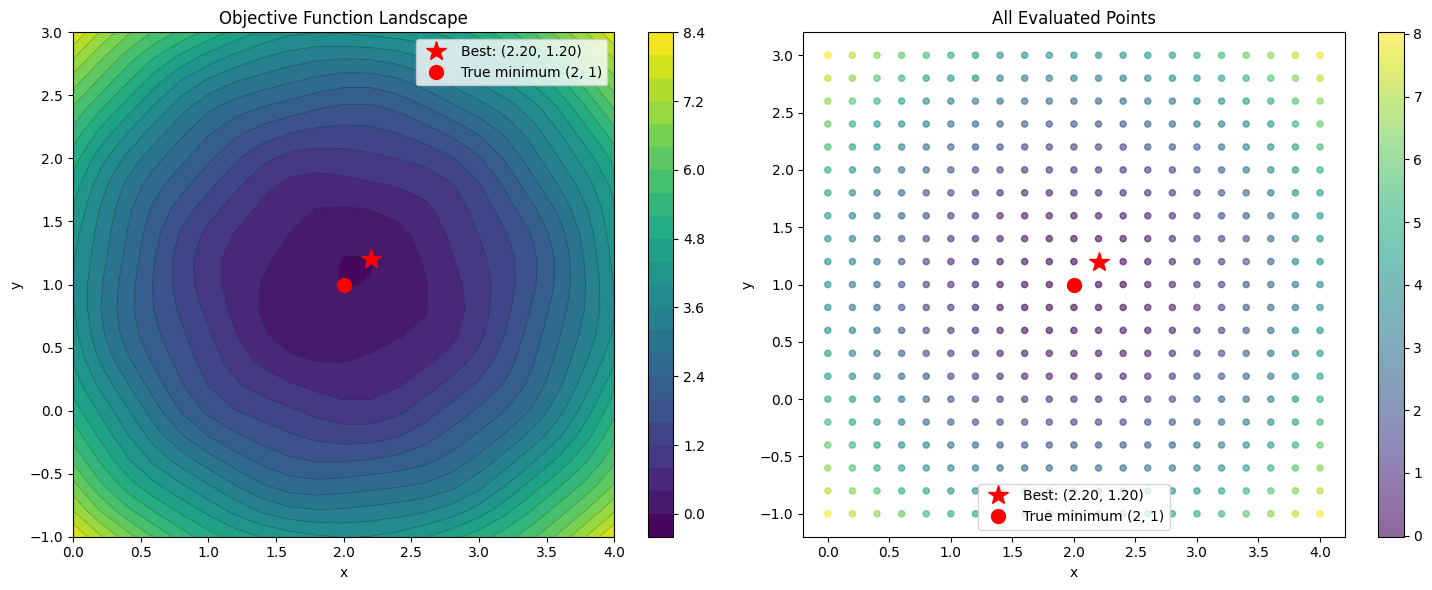

In [59]:
# Create a 2D visualization of the objective function
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Reshape results for contour plot
x_unique = jnp.unique(results["x"])
y_unique = jnp.unique(results["y"])
X, Y = jnp.meshgrid(x_unique, y_unique)

# Create Z values for contour plot
Z = jnp.zeros_like(X)
for i, x_val in enumerate(x_unique):
    for j, y_val in enumerate(y_unique):
        # Find the result for this x, y combination
        mask = (results["x"] == x_val) & (results["y"] == y_val)
        if jnp.any(mask):
            Z = Z.at[j, i].set(results["value"][mask][0])

# Contour plot
contour = ax1.contourf(X, Y, Z, levels=20, cmap="viridis")
ax1.contour(X, Y, Z, levels=20, colors="black", alpha=0.3, linewidths=0.5)
ax1.plot(best_x, best_y, "r*", markersize=15, label=f"Best: ({best_x:.2f}, {best_y:.2f})")
ax1.plot(2.0, 1.0, "ro", markersize=10, label="True minimum (2, 1)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Objective Function Landscape")
ax1.legend()
fig.colorbar(contour, ax=ax1)

# Scatter plot of all evaluated points
scatter = ax2.scatter(results["x"], results["y"], c=results["value"], cmap="viridis", alpha=0.6, s=20)
ax2.plot(best_x, best_y, "r*", markersize=15, label=f"Best: ({best_x:.2f}, {best_y:.2f})")
ax2.plot(2.0, 1.0, "ro", markersize=10, label="True minimum (2, 1)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("All Evaluated Points")
ax2.legend()
fig.colorbar(scatter, ax=ax2)

plt.tight_layout()
plt.show()

## 7. Objective Functions with Multiple Returns

Often you want to track additional metrics beyond just the primary objective. Here's how to do that:

In [60]:
def multi_output_objective(x, y):
    """
    Objective function that returns multiple values for analysis.
    """
    # Primary objective (same as before)
    primary = (x - 2.0) ** 2 + (y - 1.0) ** 2 + 0.1 * jnp.sin(5 * x) * jnp.cos(5 * y)

    # Additional metrics
    distance_from_origin = jnp.sqrt(x**2 + y**2)
    quadrant = jnp.where(
        x >= 0,
        jnp.where(y >= 0, 1, 4),  # Q1 or Q4
        jnp.where(y >= 0, 2, 3),
    )  # Q2 or Q3

    return {
        "value": primary,  # This is still the primary objective for optimization
        "distance_from_origin": distance_from_origin,
        "quadrant": quadrant,
        "x_squared": x**2,
        "y_squared": y**2,
    }


# Test the function
test = multi_output_objective(1.5, -0.5)
print("Multi-output function result:")
for key, value in test.items():
    print(f"  {key}: {value}")

Multi-output function result:
  value: 2.4248528480529785
  distance_from_origin: 1.5811388492584229
  quadrant: 4
  x_squared: 2.25
  y_squared: 0.25


In [61]:
# Clean up and run with multi-output function
if os.path.exists("results_multi"):
    shutil.rmtree("results_multi")

# Use a smaller search space for this example
small_search_space = {"x": jnp.linspace(0, 4, 11), "y": jnp.linspace(-1, 3, 11)}

grid_search_multi = DistributedGridSearch(
    objective_fn=multi_output_objective,
    search_space=small_search_space,
    progress_bar=True,
    result_dir="results_multi",
    batch_size=50,  # Process 50 combinations at a time
)

grid_search_multi.run()
results_multi = grid_search_multi.stack_results("results_multi")

print(f"\nMulti-output results keys: {list(results_multi.keys())}")
print("Best result with multiple outputs:")
for key in results_multi.keys():
    print(f"  {key}: {results_multi[key][0]}")

Process 0 will process 121 combinations with batch size 50


Processing batches on device 0/1: 100%|██████████| 3/3 [00:00<00:00, 15.04it/s]


Loading from 0 to 3 (batch size 3)


Converting to arrays: 100%|██████████| 7/7 [00:00<00:00, 866.44it/s]


Multi-output results keys: ['x', 'y', 'distance_from_origin', 'quadrant', 'value', 'x_squared', 'y_squared']
Best result with multiple outputs:
  x: 2.0
  y: 1.0
  distance_from_origin: 2.2360680103302
  quadrant: 1
  value: -0.015431823208928108
  x_squared: 4.0
  y_squared: 1.0


## 8. Memory Considerations

For large search spaces, memory management becomes important. The automatic memory-based batch sizing works best on GPU/TPU devices, while CPU defaults to batch size 64. You can control batch sizes and memory usage:

In [62]:
# Example of manual batch size control
print("Different batch size strategies:\n")

# Strategy 1: Automatic batch sizing (default)
print("1. Automatic batch sizing (memory-based):")
auto_grid = DistributedGridSearch(
    objective_fn=simple_objective, search_space={"x": jnp.linspace(0, 1, 50), "y": jnp.linspace(0, 1, 50)}, progress_bar=False
)
print(f"   Automatically selected batch size: {auto_grid.batch_size}")

# Strategy 2: Manual batch size
print("\n2. Manual batch sizing:")
manual_grid = DistributedGridSearch(
    objective_fn=simple_objective,
    search_space={"x": jnp.linspace(0, 1, 50), "y": jnp.linspace(0, 1, 50)},
    batch_size=100,  # Fixed batch size
    progress_bar=False,
)
print(f"   Manually set batch size: {manual_grid.batch_size}")

# Strategy 3: Memory limit control
print("\n3. Memory limit control:")
memory_grid = DistributedGridSearch(
    objective_fn=simple_objective,
    search_space={"x": jnp.linspace(0, 1, 50), "y": jnp.linspace(0, 1, 50)},
    memory_limit=0.3,  # Use only 30% of available memory
    progress_bar=False,
)
print(f"   Memory-limited batch size: {memory_grid.batch_size}")

total_combinations = 50 * 50
print(f"\nTotal combinations to evaluate: {total_combinations}")


                    Batch size not specified and automatic batch size
                    determination is not supported on CPU.
                    Falling back to default batch size of 64.
                    

                    Batch size not specified and automatic batch size
                    determination is not supported on CPU.
                    Falling back to default batch size of 64.
                    


Different batch size strategies:

1. Automatic batch sizing (memory-based):
Process 0 will process 2500 combinations with batch size 64
   Automatically selected batch size: 64

2. Manual batch sizing:
Process 0 will process 2500 combinations with batch size 100
   Manually set batch size: 100

3. Memory limit control:
Process 0 will process 2500 combinations with batch size 64
   Memory-limited batch size: 64

Total combinations to evaluate: 2500


## 9. Cleanup and Best Practices

Let's clean up the result files and summarize best practices:

**Key Best Practices:**
1. **Objective Function Design**: Always return a dictionary with `"value"` key, use JAX operations (`jnp`)
2. **Search Space**: Use reasonable ranges around expected optima, consider grid resolution vs computation cost  
3. **Memory Management**: Let automatic batch sizing handle memory on GPU/TPU, use manual batch size for CPU
4. **Result Handling**: Use `result_dir` for intermediate saves, `stack_results()` for aggregation
5. **Distributed Computing**: Use MPI with `jax.distributed.initialize()` for large-scale searches

In [63]:
# Cleanup result directories
for directory in ["results", "results_multi"]:
    if os.path.exists(directory):
        shutil.rmtree(directory)
        print(f"Cleaned up {directory}/")

Cleaned up results/
Cleaned up results_multi/
